# LSTM track-finding model for 2D detector layers

In this notebook we extend the method of the "simple" LSTM on 1D detector layer data to 2D detector layers, using the data functionality developed in the DataGen2D notebook.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt

# Magic
%matplotlib notebook

## Utilities

In [4]:
def draw_layer(ax, data, title=None, **kwargs):
    """Draw one detector layer as an image"""
    ax.imshow(data.T, interpolation='none', aspect='auto',
              origin='lower', **kwargs)
    if title is not None:
        ax.set_title(title)

def draw_layers(event, ncols=5, figsize=(9.5, 4.5)):
    """Draw each detector layer as a grid of images"""
    num_layers = event.shape[0]
    nrows = math.ceil(float(num_layers)/ncols)
    plt.figure(figsize=figsize)
    for ilay in range(num_layers):
        ax = plt.subplot(nrows, ncols, ilay+1)
        title = 'layer %i' % ilay
        draw_layer(ax, event[ilay], title=title)
    plt.tight_layout()

In [5]:
def gen_noise_2d(shape, prob=0.1):
    return (np.random.random_sample(shape) < prob).astype(int)

def gen_straight_tracks_2d(n, num_layers, layer_size):
    # Initialize the data
    data = np.zeros((n, num_layers, layer_size, layer_size))
    # Sample the entry and exit points for tracks
    entry_points = np.random.uniform(0, layer_size, size=(n, 2))
    exit_points = np.random.uniform(0, layer_size, size=(n, 2))
    # Calculate slope parameters
    slopes = (exit_points - entry_points) / float(num_layers - 1)
    # Calculate hit positions and fill hit data
    xhits = np.zeros(num_layers, dtype=np.int)
    yhits = np.zeros(num_layers, dtype=np.int)
    idx = np.arange(num_layers)
    for ievt in range(n):
        xhits[:] = slopes[ievt,0]*idx + entry_points[ievt,0]
        yhits[:] = slopes[ievt,1]*idx + entry_points[ievt,1]
        data[ievt,idx,xhits,yhits] = 1   
    return data

def gen_bkg_tracks_2d(num_event, num_layers, layer_size, avg_bkg_tracks=3):
    num_bkg_tracks = np.random.poisson(avg_bkg_tracks, num_event)
    bkg_tracks = np.zeros((num_event, num_layers, layer_size, layer_size))
    for ievt in range(num_event):
        ntrk = num_bkg_tracks[ievt]
        bkg_tracks[ievt] = sum(gen_straight_tracks_2d(ntrk, num_layers, layer_size))
    return bkg_tracks

## Configuration

In [3]:
num_event = 100000
num_layers = 10
num_seed_layers = 3
layer_size = 20
shape = (num_event, num_layers, layer_size, layer_size)

## Data generation

In [6]:
# Signal tracks
sig_tracks = gen_straight_tracks_2d(num_event, num_layers, layer_size)

# Background tracks
bkg_tracks = gen_bkg_tracks_2d(num_event, num_layers, layer_size)
bkg_tracks[:,:num_seed_layers,:,:] = 0

# Noise
noise = gen_noise_2d(shape, prob=0.01)
noise[:,:num_seed_layers,:,:] = 0

# Full events
events = sig_tracks + bkg_tracks + noise
events[events > 1] = 1

<IPython.core.display.Javascript object>


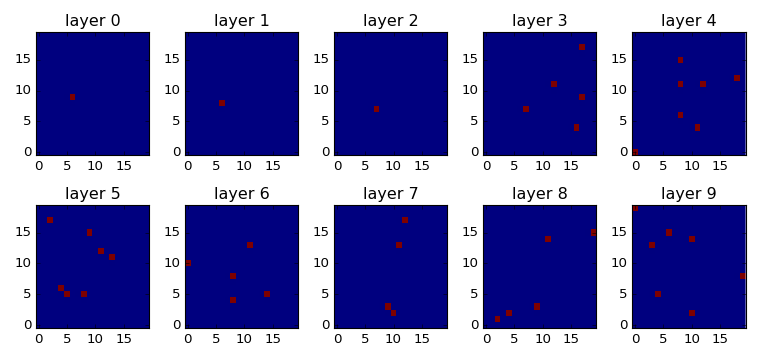

In [7]:
# Visualize one event
draw_layers(events[0])

## Define the model

In [ ]:
# FINISH ME
def build_model(num_hidden=10, length=det_depth-1, dim=det_width,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model